In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
import scipy as sp

2023-10-06 13:05:07.607932: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
ds = []
for i in range(5): 
    ind = np.load('data_dic_' + str(i+1) + '.npy',allow_pickle='TRUE').item()
    ds.append(ind)

In [3]:
ds_num = np.random.randint(5)

c = sp.constants.c # speed of light
fc = 3.5e9 # or 28 GHz
Nrays = 20 # number of rays
BW = 100e6

pow = np.transpose(10**(0.1*(ds[ds_num]['pows'][()][()][()])), [1,0,2]) #first measurement campaign in Watt
phase = np.transpose(ds[ds_num]['phase'][()][()][()], [1,0,2]) #first measurement campaign in Radian

#ZoD = np.transpose((np.pi/180)*ds[ds_num]['ZoDs'][()][()][()], [1,0,2]) #first measurement campaign in Radian --> elevation angle of departure(theta)
#AoD = np.transpose((np.pi/180)*ds[ds_num]['AoDs'][()][()][()], [1,0,2]) #first measurement campaign in Radian --> azimuth angle of departure (phi)
 
#ZoA = np.transpose((np.pi/180)*ds[ds_num]['ZoAs'][()][()][()], [1,0,2]) 
#AoA = np.transpose((np.pi/180)*ds[ds_num]['AoAs'][()][()][()], [1,0,2]) 

delay = np.transpose(ds[ds_num]['delays'][()][()][()], [1,0,2])
LOS = np.transpose(ds[ds_num]['LOS'][()][()][()],[1,0]) #first measurement campaign in Radian --> azimuth angle of arrivial (phi)
#K_R = np.transpose(10**(0.1*(ds[ds_num]['K'][()][()][()])), [1,0]) #in linear scale

x = ds[ds_num]['x'][()][()][()] #first measurement campaign in Radian --> azimuth angle of arrivial (phi)
y = ds[ds_num]['y'][()][()][()] #first measurement campaign in Radian --> azimuth angle of arrivial (phi)
z = ds[ds_num]['z'][()][()][()] #first measurement campaign in Radian --> azimuth angle of arrivial (phi)

tx_x= ds[ds_num]['tx_x'][()][()][()] #first measurement campaign in Radian --> azimuth angle of arrivial (phi)
tx_y = ds[ds_num]['tx_y'][()][()][()] #first measurement campaign in Radian --> azimuth angle of arrivial (phi)
tx_z = ds[ds_num]['tx_z'][()][()][()] #first measurement campaign in Radian --> azimuth angle of arrivial (phi)

print(f'Current random selected dataset is: {ds_num}')
print(f'The shape of channel coefficient parameters are: \n pow = {pow.shape} \n phase = {phase.shape}')
print(f'The shape of Delay and LOS profile is are: \n delay = {delay.shape} \n LOS = {LOS.shape}')
print(f'The shape of dataset of cartesian coordinate system is \n x = {x.shape} \n y = {y.shape} \n z = {z.shape} \n tx_x = {tx_x.shape} \n tx_y = {tx_y.shape} \n tx_z = {tx_z.shape}')
print(f'LOS/NLOS label counts: {np.unique(LOS[:,0], return_counts=True)}')

Current random selected dataset is: 2
The shape of channel coefficient parameters are: 
 pow = (7090, 18, 20) 
 phase = (7090, 18, 20)
The shape of Delay and LOS profile is are: 
 delay = (7090, 18, 20) 
 LOS = (7090, 18)
The shape of dataset of cartesian coordinate system is 
 x = (18, 7090) 
 y = (18, 7090) 
 z = (18, 7090) 
 tx_x = (18,) 
 tx_y = (18,) 
 tx_z = (18,)
LOS/NLOS label counts: (array([1.1, 2.1]), array([6498,  592]))


# visualization of CIR for four random TRPs

General formula for channel impulse response: 
\begin{equation*}
CIR = h(\tau,t) = \sum \limits_{l=1}^{N} \alpha_{l}(t) \delta(\tau - \tau_{i}(t))
\end{equation*}
**CIR** is defined by equation and path gains are complex numbers in the form of $\alpha{e^{arg(\alpha)}}$


**by looking at our dataset, it seems that**: <br>
Tx-Rx pairs are stationary --> CIR is time independent. i.e, 
$CIR = h(\tau) = \sum \limits_{l=1}^{20} \alpha_{l} \delta(\tau - \tau_{i})$ & $\alpha_{l}$ is in the form of $\alpha_l = Ae^{j\theta}$ <br>



In [4]:
# making CIR according to TR 38.901
CIR = (1/np.sqrt(Nrays))*pow*np.exp(1j*phase)
#r_tx = np.exp(2*np.pi*(fc/c)*1j*(np.array((np.sin(ZoD)*np.cos(AoD), np.sin(ZoD)*np.sin(AoD), np.cos(ZoD)))))
#r_rx = np.exp(2*np.pi*(fc/c)*1j*(np.array((np.sin(ZoA)*np.cos(AoA), np.sin(ZoA)*np.sin(AoA), np.cos(ZoA)))))
#CIR = G*r_tx*r_rx

# scaling the first tap for LOS data according to rician-k factor
#for i in np.arange(CIR.shape[1]):
#    for j in np.arange(CIR.shape[2]):
#        if LOS[i,j] == 1.1:
#            d_3D = np.sqrt((tx_x[j] - x[j,i])**2 + (tx_y[j] - y[j,i])**2 + (tx_z[j] - z[j,i])**2) 
#            CIR[:,i,j,0] = np.sqrt(K_R[i,j]/(K_R[i,j]+1))*(1/np.sqrt(Nrays))*pow[i,j,0]*r_tx[:,i,j,0]*r_rx[:,i,j,0]*np.exp(-1j*2*np.pi*fc/c*d_3D)
#            CIR[:,i,j,1:] = np.sqrt(1/(K_R[i,j]+1))*CIR[:,i,j,1:]

#CIR = np.transpose(CIR, [1,2,0,3])
print(f'The shape of CIR = {CIR.shape}')

The shape of CIR = (7090, 18, 20)


In [5]:
LOS_labels = np.where(LOS == 1.1, 0, 1) #where true yeals o, otherwise yield one
zero_indices = np.argwhere(LOS_labels == 0)
one_indices = np.argwhere(LOS_labels == 1)
#p_LOS = zero_indices[np.random.choice(len(zero_indices))]
#p_NLOS = one_indices[np.random.choice(len(zero_indices))]
ind = one_indices[np.random.choice(one_indices.shape[0])]
ind

array([6607,    6])

shape of a random CIR is (20,)


"ax[2][1].stem(abs(u[2,:])*1e6)\nax[2][1].set_ylabel(r'Elevation power [$\\mu$W]')\nax[2][1].set_xlabel('Time lags')\nax[2][1].set_xticks(np.arange(0,20,1))\nax[0][1].set_title(f'TRP point: Rx = {p}, Tx = {b}, ds = {ds_num}', loc = 'right')"

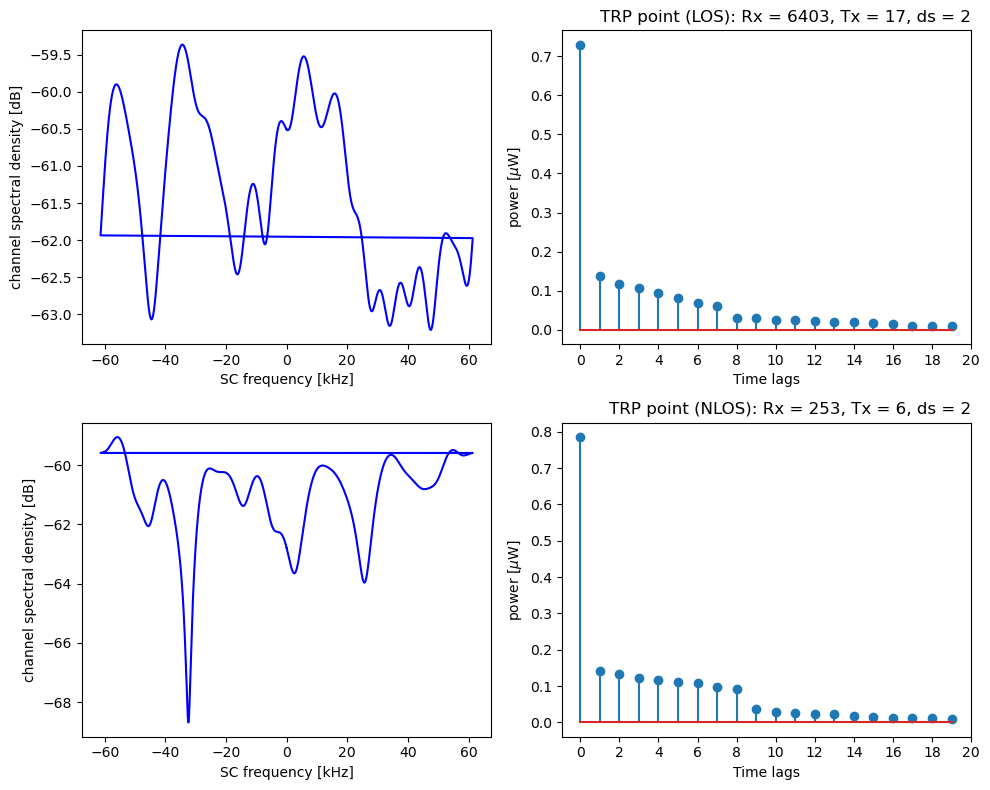

In [6]:
LOS_labels = np.where(LOS == 1.1, 0, 1) #where true yeals o, otherwise yield one
zero_indices = np.argwhere(LOS_labels == 0)
one_indices = np.argwhere(LOS_labels == 1)
random_ind_LOS = zero_indices[np.random.choice(zero_indices.shape[0])]
random_ind_NLOS = zero_indices[np.random.choice(one_indices.shape[0])]

u_LOS = CIR[random_ind_LOS[0], random_ind_LOS[1], :]
u_NLOS = CIR[random_ind_NLOS[0], random_ind_NLOS[1], :]
print('shape of a random CIR is {}'.format(u_LOS.shape))

SC_BW  = 60e3; #120e3 or 30e3
nFFT = 2048
Ts = 1/(SC_BW*nFFT)
freq = np.fft.fftfreq(nFFT, Ts) / 1e6 #giga hz to mega hz

fig, ax = plt.subplots(2,2, figsize=(10,8))
ax[0][0].plot(freq, 10 * np.log10(abs(np.fft.fft(u_LOS, nFFT))), 'b')
ax[0][0].set_ylabel('channel spectral density [dB]')
ax[0][0].set_xlabel('SC frequency [kHz]')

ax[1][0].plot(freq, 10 * np.log10(abs(np.fft.fft(u_NLOS, nFFT))), 'b')
ax[1][0].set_ylabel('channel spectral density [dB]')
ax[1][0].set_xlabel('SC frequency [kHz]')

"""ax[2][0].plot(freq, 10 * np.log10(abs(np.fft.fft(u[2,:], nFFT))), 'b')
ax[2][0].set_ylabel('Elevation power spectral [dB]')
ax[2][0].set_xlabel('SC frequency [kHz]')"""

ax[0][1].stem(abs(u_LOS)*1e6)
ax[0][1].set_ylabel(r'power [$\mu$W]')
ax[0][1].set_xlabel('Time lags')
ax[0][1].set_xticks(np.arange(0,21,2))
ax[0][1].set_title(f'TRP point (LOS): Rx = {random_ind_LOS[0]}, Tx = {random_ind_LOS[1]}, ds = {ds_num}', loc = 'right')

ax[1][1].stem(abs(u_NLOS)*1e6)
ax[1][1].set_ylabel(r'power [$\mu$W]')
ax[1][1].set_xlabel('Time lags')
ax[1][1].set_xticks(np.arange(0,21,2))
ax[1][1].set_title(f'TRP point (NLOS): Rx = {random_ind_NLOS[0]}, Tx = {random_ind_NLOS[1]}, ds = {ds_num}', loc = 'right')
plt.tight_layout()

"""ax[2][1].stem(abs(u[2,:])*1e6)
ax[2][1].set_ylabel(r'Elevation power [$\mu$W]')
ax[2][1].set_xlabel('Time lags')
ax[2][1].set_xticks(np.arange(0,20,1))
ax[0][1].set_title(f'TRP point: Rx = {p}, Tx = {b}, ds = {ds_num}', loc = 'right')"""

In [7]:
OFDM_withCP = np.load('OFDM_withCP.npy',allow_pickle='TRUE')
PRS = np.transpose(OFDM_withCP, [1,2,0])[2:7,:,:] #select thoes symbols that contain PRS
print ("PRS with CP shape is: ", PRS.shape)

PRS with CP shape is:  (5, 18, 2048)


## RX maker

In [8]:
class RXmaker:
    def __init__(self, bs_id_, SNRdB_, PRS_, CIR_):
        
        self.nFFT = 2048
        self.SC_BW  = 60e3 #120e3 or 30e3
        self.Ts = 1/(self.SC_BW*self.nFFT)
        self.freq = np.fft.fftfreq(self.nFFT, self.Ts) / 1e6 #giga hz to mega hz
        
        self.SNRdB = SNRdB_
        self.bs_id = bs_id_

        
        self.PRS = self.get_signal(PRS_)
        self.CIR = self.get_signal(CIR_)
        self.CFR = self.fft_transform()
        
    def get_signal(self, signal):
        if len(signal.shape) == 4:
            return signal[:,self.bs_id,:,:] #self.flatten(signal[:,self.bs_id,:,:])
        
        if len(signal.shape) == 3:
            return signal[:,self.bs_id,:] 
        
    def fft_transform(self):
        return np.fft.fft(self.CIR, n = self.nFFT, axis = 1)
    
    def flatten(self, signal):
        return signal.reshape((signal.shape[0], -1))

    def shape_alignment(self):
        self.PRS = self.PRS[np.newaxis, :] 
        #self.PRS = np.transpose(np.repeat(self.PRS[:, np.newaxis], repeats = 3, axis = 0), [1,2,0,3])
        self.CFR = np.repeat(self.CFR[:,np.newaxis], repeats = 5, axis = 1) 
        return self 

    #@tf.function
    def RX_freq(self):
        self.shape_alignment()
        return np.multiply(self.PRS, self.CFR)
    
    def NoiseGenerator(self):
        np.random.seed(123)
        #mean = 0
        self.sigma_2 = self.signal_power * 10**(-self.SNRdB/10)
        return np.sqrt(self.sigma_2[:,:,np.newaxis]*0.5)*(np.random.randn(*self.CFR.shape)+1j*np.random.randn(*self.CFR.shape))
    #tf.complex(tf.random.normal(self.CFR.shape, mean, self.std), tf.random.normal(self.CFR.shape, mean, self.std))
    
    def RX_time(self):
        freq = self.RX_freq()
        RX = self.ifft_transform(freq)
        self.signal_power = np.mean(abs(RX), axis = 2)
        return RX
    
    def PRS_time(self):
        return np.squeeze(self.ifft_transform(self.PRS))
    
    def ifft_transform(self, signal):
        return np.fft.ifft(signal, n = self.nFFT, axis = 2)

    def set_output(self, mode):
        self.mode = mode
        if mode == 'Noisy':
            RX = self.RX_time() + self.NoiseGenerator()
        if mode == 'NotNoisy':
            RX = self.RX_time()
        PRS_time = self.PRS_time()
        self.get_info()
        return RX, PRS_time 
    
    def get_info(self):
        print('Shape of input signals, PRS and CIR is {}, {}'.format(self.PRS.shape, self.CIR.shape))
        print(f'CFR, PRS alignment is performed,\nRepeated CIR for 5 symbols, and one dummy axis for multiplication\nFinal shape is {self.CFR.shape}, {self.PRS.shape}')
        if self.mode == 'Noisy':
            print('SNR = {:.6f}'.format(self.SNRdB))

## ToA Estimator 
i.e. Correlation with interpolation or without interpolation

In [9]:
class TOAEstimator:
    def __init__(self, RX, PRS_time, nFFT, oversampling):
        self.oversampling = oversampling 
        self.nFFT = nFFT
        self.PRS = PRS_time
        self.RX = RX

#data_oversampled = np.repeat(data, oversampling_factor, axis=2)
    def interpolation(self):
        from scipy.interpolate import interp1d

        original_time_points = np.arange(self.nFFT)
        oversampled_time_points = np.linspace(0, self.nFFT-1, self.nFFT*self.oversampling)

        self.interpolated_rx = np.empty((self.RX.shape[0], self.RX.shape[1], self.nFFT*self.oversampling), dtype=complex)

        for i in np.arange(0,self.RX.shape[0],1):
            for j in np.arange(0,self.RX.shape[1],1):
                f = interp1d(original_time_points, self.RX[i,j,:], kind='linear')
                self.interpolated_rx[i, j, :] = f(oversampled_time_points)

        self.interpolated_prs = np.empty((self.PRS.shape[0], self.nFFT*self.oversampling), dtype=complex)
        for i in np.arange(0, self.PRS.shape[0], 1):
            f = interp1d(original_time_points, self.PRS[i,:], kind='linear')
            self.interpolated_prs[i, :] = f(oversampled_time_points)
        
        return self.interpolated_rx, self.interpolated_prs
# Now, interpolated_data has the shape (7102, 5, 20480) with oversampled data

    
    def correlation(self, mode):
        self.mode = mode
        if mode == 'Interp':
            RX, PRS = self.interpolation()
            self.cor_signal = np.empty((self.RX.shape[0], self.RX.shape[1], self.nFFT*self.oversampling), dtype = complex)

        if mode == 'NoInterp':
            RX, PRS = self.RX, self.PRS
            self.cor_signal = np.empty((RX.shape[0], RX.shape[1], self.nFFT), dtype = complex)

        for i in np.arange(0,RX.shape[0],1):
            for j in np.arange(0,self.RX.shape[1],1):
                cor = signal.correlate(PRS[j,:], RX[i,j,:], mode='same')
                self.cor_signal[i,j,:] = cor
        return self
    
    def set_output(self):
        self.get_info()
        return self.cor_signal
    
    def get_info(self):
        if self.mode == 'Interp':
            print('Interpolation is performed, the shape of RX and PRS is {}, {}'.format(self.interpolated_rx.shape, self.interpolated_prs.shape))
            print(f'Correlation operation is performed, the shape of correlation sequence is {self.cor_signal.shape}')
        if self.mode == 'NoInterp':
            print('No interpolation')
            print(f'Correlation operation is performed, the shape of correlation sequence is {self.cor_signal.shape}')

## Feature Extractor
This class depends on an input sequence, i.e. basically it gets the RX received signal and extract statistical features based on PDP. 
However, the output of correlation operation can be also logically used as a input for this class.    

In [10]:
class FeatureExtractor:
    def __init__(self, RX, nFFT):
        self.nFFT = nFFT
        self.SC = 60e3 #numerology of two, subcarrier spacing
        self.Ts = 1/self.SC*self.nFFT
        BW = self.SC * self.nFFT
        #self.delay = np.linspace(0, Ts, RX.shape[-1])
        self.delay = np.indices(RX.shape)[2] /BW
        self.pow = abs(RX)
        self.phase = np.angle(RX)

    def Average_power(self):
        return np.sum(self.pow, axis = 2)
    
    def MED(self):
        pow_ave = self.Average_power()
        return (1/pow_ave)*np.sum(self.delay*self.pow, axis = 2) # Mean excess delay
    
    def RMS_DS(self):
        pow_ave = self.Average_power()
        MED = self.MED()
        return (1/pow_ave)*(np.sum((np.transpose(np.array([(self.delay[:,:,i] - MED)**2 for i in np.arange(0,self.delay.shape[2],1)]), [1,2,0])*self.pow), axis = 2))

    def R_max(self):
        return np.max(np.apply_along_axis(np.sqrt, 2, self.pow), axis = 2)
    
    def Rise_time(self):
        r_max = self.R_max()
        sigma_n = 1 # standard deviation of thermal noise
        alpha = 6
        beta = 0.6 
        r_t = np.apply_along_axis(np.sqrt, 2, self.pow) 
        a_H = np.argmin(np.transpose(np.array([np.where( r_t[:,:,i] > r_max[:,:]*beta, r_t[:,:,i], r_max[:,:]*beta) for i in np.arange(0,self.pow.shape[2],1)]), [1,2,0]), axis = 2)
        a_L = np.argmin(np.transpose(np.array([np.where( r_t[:,:,i] > sigma_n*alpha, r_t[:,:,i], sigma_n*alpha) for i in np.arange(0,self.pow.shape[2],1)]), [1,2,0]), axis = 2)

        t_H = np.empty((a_H.shape[0],a_H.shape[1]))
        t_L = np.empty((a_L.shape[0],a_L.shape[1]))
        
        for i in np.arange(0,a_H.shape[0],1):
            for j in np.arange(0,a_H.shape[1],1):
                t_H[i,j] = delay[i,j, a_H[i,j]]

        for i in np.arange(0,a_L.shape[0],1):
            for j in np.arange(0,a_L.shape[1],1):
                t_L[i,j] = delay[i,j, a_L[i,j]]


        t_rise = t_H - t_L

        return t_rise
    
    def Kurtosis(self):
        r_t = np.apply_along_axis(np.sqrt, 2, self.pow) 
        t_ave = np.sum(self.delay, axis = 2)
        mu_r = (1/t_ave)*np.sum(r_t, axis = 2)
        sigma_r = (1/delay.shape[2])*(np.sum((np.transpose(np.array([(r_t[:,:,i] - mu_r)**2 for i in np.arange(0,20,1)]), [1,2,0])), axis = 2))
        sigma_four = np.apply_along_axis(np.square, 1, sigma_r)
        kur = (1/(t_ave*sigma_four))*(np.sum((np.transpose(np.array([(r_t[:,:,i] - mu_r)**4 for i in np.arange(0,20,1)]), [1,2,0])), axis = 2))
        return kur
    
    def set_output(self):
        ave_pow = self.Average_power()
        MED = self.MED()
        RMS_DS = self.RMS_DS()
        r_max = self.R_max()
        Rise_time = self.Rise_time()
        Kurtosis = self.Kurtosis()
        print(f'the shape of maximum amplitude is {r_max.shape}')
        print(f'the shape of average power or received signal energy is {ave_pow.shape}')
        print(f'the shape of mean excess delay (MED) or poweer delay profile (PDP) is {MED.shape}')
        print(f'the shape of RMS delay spread is {RMS_DS.shape}')
        print(f'the shape of rise time is {Rise_time.shape}')
        print(f'the shape of Kurtosis is {Kurtosis.shape}')
        return np.transpose(np.stack((ave_pow, MED, RMS_DS, r_max, Rise_time, Kurtosis)), [1,2,0])

In [11]:
bs_id  = np.random.randint(18) 
SNRdB = 20
oversampling = 10
RX_time_noisy, PRS_time = RXmaker(bs_id,SNRdB,PRS, CIR).set_output('Noisy')
RX_time_noNoise, _ = RXmaker(bs_id,SNRdB,PRS, CIR).set_output('NotNoisy')

#'Interp' means correlation with interpolation, #'NoInterp' means correlation without Interpolation
cor_noisy = TOAEstimator(RX_time_noisy, PRS_time, nFFT, oversampling).correlation('NoInterp').set_output() 
cor_noNoise = TOAEstimator(RX_time_noNoise, PRS_time, nFFT, oversampling).correlation('NoInterp').set_output() 

Shape of input signals, PRS and CIR is (1, 5, 2048), (7090, 20)
CFR, PRS alignment is performed,
Repeated CIR for 5 symbols, and one dummy axis for multiplication
Final shape is (7090, 5, 2048), (1, 5, 2048)
SNR = 20.000000
Shape of input signals, PRS and CIR is (1, 5, 2048), (7090, 20)
CFR, PRS alignment is performed,
Repeated CIR for 5 symbols, and one dummy axis for multiplication
Final shape is (7090, 5, 2048), (1, 5, 2048)
No interpolation
Correlation operation is performed, the shape of correlation sequence is (7090, 5, 2048)
No interpolation
Correlation operation is performed, the shape of correlation sequence is (7090, 5, 2048)


In [12]:
FE_noisy = FeatureExtractor(RX_time_noisy, nFFT).set_output()
FE_noNoise = FeatureExtractor(RX_time_noNoise, nFFT).set_output()
print('The shape of stacked feature array is {}'.format(FE_noisy.shape))

the shape of maximum amplitude is (7090, 5)
the shape of average power or received signal energy is (7090, 5)
the shape of mean excess delay (MED) or poweer delay profile (PDP) is (7090, 5)
the shape of RMS delay spread is (7090, 5)
the shape of rise time is (7090, 5)
the shape of Kurtosis is (7090, 5)
the shape of maximum amplitude is (7090, 5)
the shape of average power or received signal energy is (7090, 5)
the shape of mean excess delay (MED) or poweer delay profile (PDP) is (7090, 5)
the shape of RMS delay spread is (7090, 5)
the shape of rise time is (7090, 5)
the shape of Kurtosis is (7090, 5)
The shape of stacked feature array is (7090, 5, 6)


In [13]:
np.save('RX_time.npy', RX_time_noisy)
np.save('LOS.npy', LOS)
np.save('FE.npy', FE_noisy)
np.save('cor.npy', cor_noisy)
#These values are saved to be called again as a different input array for ML model

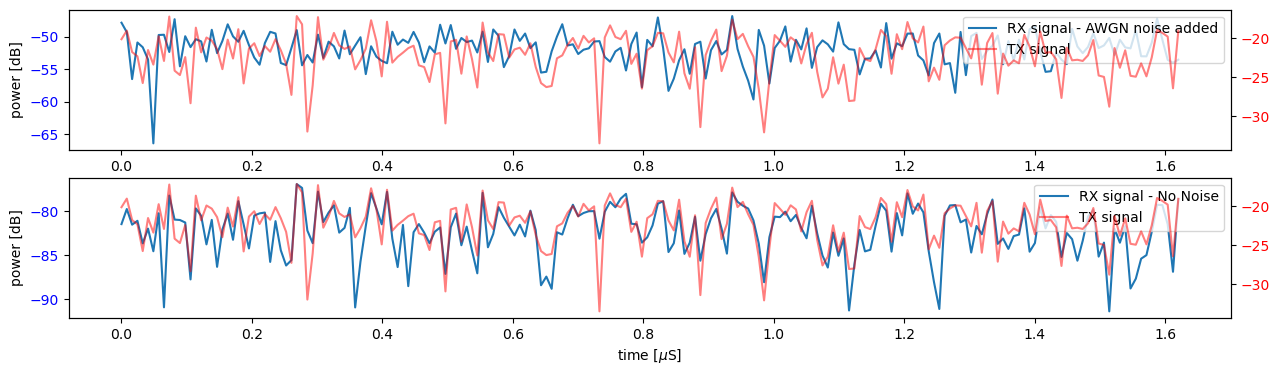

In [14]:
SC = 60 #numerology of two, subcarrier spacing
nFFT = 2048
Ts = 1e3/SC
t = np.linspace(0, Ts, nFFT)
fig, (ax1, ax3) = plt.subplots(2,1,figsize=(15,4))
ax1.plot(t[:200], 10*np.log10(abs(RX_time_noisy[50,0,:200])), label='RX signal - AWGN noise added')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xlabel(r'time [$\mu$S]')
ax1.set_ylabel('power [dB]')
ax2 = ax1.twinx()
ax2.plot(t[:200], 10*np.log10(abs(PRS_time[0,:200])), color = 'r', label='TX signal', alpha = 0.5)
ax2.tick_params(axis='y', labelcolor='r')
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

ax3.plot(t[:200], 10*np.log10(abs(RX_time_noNoise[50,0,:200])), label='RX signal - No Noise')
ax3.tick_params(axis='y', labelcolor='b')
ax3.set_xlabel(r'time [$\mu$S]')
ax3.set_ylabel('power [dB]')
ax4 = ax3.twinx()
ax4.plot(t[:200], 10*np.log10(abs(PRS_time[0,:200])), color = 'r', label='TX signal', alpha = 0.5)
ax4.tick_params(axis='y', labelcolor='r')
lines, labels = ax3.get_legend_handles_labels()
lines2, labels2 = ax4.get_legend_handles_labels()
ax3.legend(lines + lines2, labels + labels2, loc='upper right')


/home/hamed/miniconda3/envs/tf/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


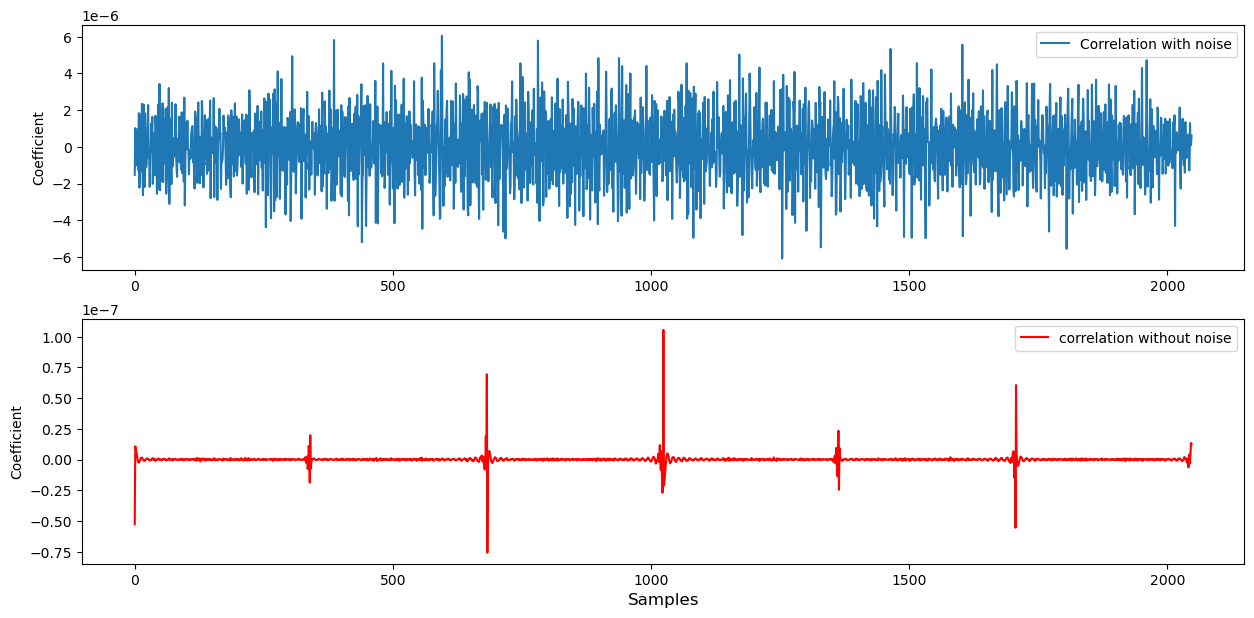

In [15]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(15,7))
ax1.plot(cor_noisy[50,0,:], label='Correlation with noise')
ax1.legend()
#ax1.set_xlabel(r'Time [$\mu$s]')
ax1.set_ylabel('Coefficient')
ax2.plot(cor_noNoise[50,0,:], color = 'red', label='correlation without noise')
ax2.set_xlabel(r'Samples', fontsize = 12)
ax2.set_ylabel('Coefficient')
ax2.legend()

In [16]:
fs = 1/Ts
s = RX_time_noisy[:,0,:]
signals = []
for i in range(RX_time_noisy.shape[0]):
    frequencies, times, Sxx = signal.spectrogram(s[i,:], fs, return_onesided=False)
    signals.append(Sxx)
da_Sxx = np.array(signals)
#np.save('Sxx.npy', da_Sxx)
da_Sxx.shape

(7090, 256, 9)

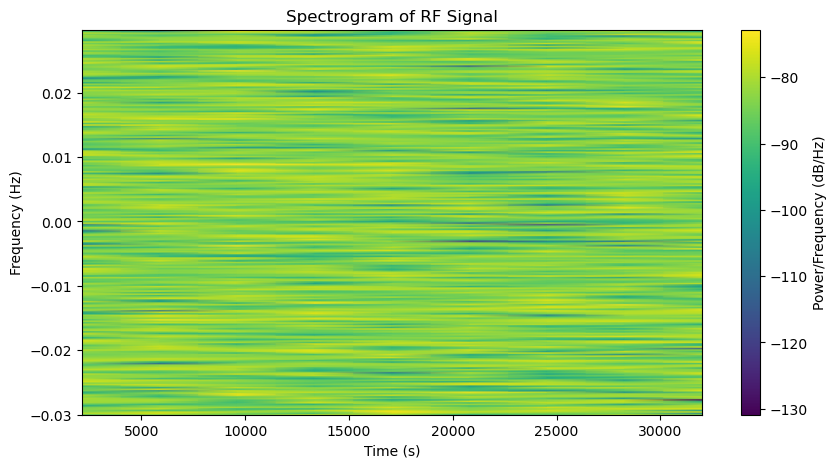

In [17]:
plt.figure(figsize=(10, 5))
plt.pcolormesh(times, sp.fft.fftshift(frequencies), 10 * np.log10(sp.fft.fftshift(da_Sxx[3241,:,:], axes = 0)), shading='gouraud')
plt.colorbar(label='Power/Frequency (dB/Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.title('Spectrogram of RF Signal')
plt.show()

In [18]:
data = np.transpose(np.stack((np.abs(RX_time_noisy), np.angle(RX_time_noisy)), axis = 3), [0,1,3,2])
labels = LOS_labels[:,bs_id]
print('input shape of CNN is : {}'.format(data.shape))
print('shape of LOS/NLOS labels are : {}'.format(np.unique(labels, return_counts=True)))
print('current BS_ID is : {}'.format(bs_id))

input shape of CNN is : (7090, 5, 2, 2048)
shape of LOS/NLOS labels are : (array([0, 1]), array([6709,  381]))
current BS_ID is : 17


Text(0, 0.5, 'Coefficient')

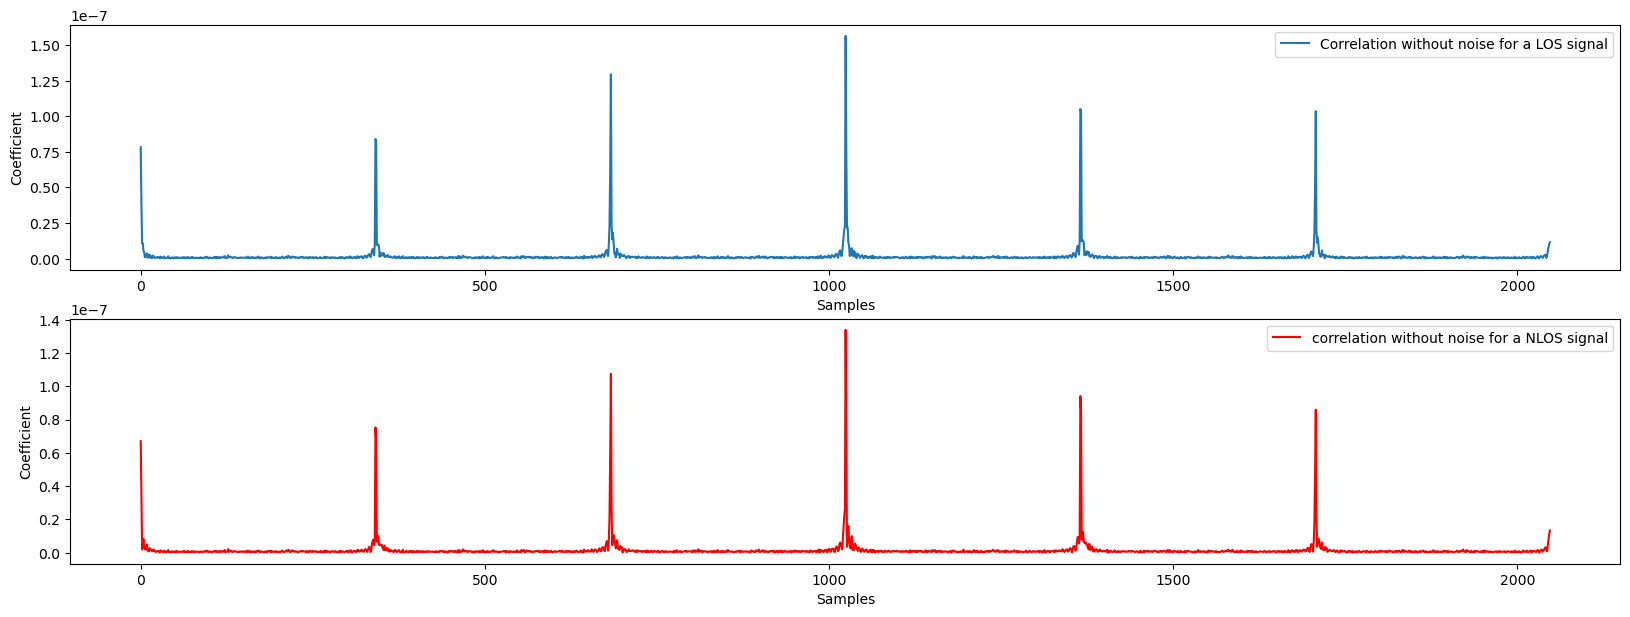

In [25]:
np.random.seed(23)
p_LOS = np.random.randint(0, len(np.argwhere(labels == 0))) #a ranodm LOS point for correlation
p_NLOS = np.random.randint(0, len(np.argwhere(labels == 1))) #a random NLOS reception point 

cor1 = signal.correlate(RX_time_noNoise[p_LOS,0,:] , PRS_time[0,:], 'same') 
#cor1 /= np.max(cor1)
cor2 = signal.correlate(RX_time_noNoise[p_NLOS,0,:] , PRS_time[0,:], 'same') 
#cor2 /= np.max(cor2) #for coefficient standardization

fig, (ax1, ax2) = plt.subplots(2,1,figsize=(20,7))
ax1.plot(abs(cor1[:]), label='Correlation without noise for a LOS signal')
ax1.set_xlabel('Samples')
ax1.set_ylabel('Coefficient')
ax1.legend()
ax2.plot(abs(cor2[:]), color = 'red', label='correlation without noise for a NLOS signal')
ax2.legend()
ax2.set_xlabel('Samples')
ax2.set_ylabel('Coefficient')
      